In [1]:
import os
import sys
import importlib
from contextlib import redirect_stdout
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
import seaborn as sns
import polars as pl
# sys.path.append(os.path.abspath('../Libraries'))
import volpe_library_2 as vl2 # type: ignore
# Forcing the reload of vl2 without the need of a jp kernel restart
with redirect_stdout(open(os.devnull, 'w')):
    importlib.reload(vl2)

In [2]:
# Apply the default theme
sns.set_style("whitegrid")
# Set default figure size globally
plt.rcParams['figure.figsize'] = [12, 6]

# Data from simulation

In [33]:
# load simulation data
df_sim_Ar40 = pl.read_parquet(r"C:\Users\jzielins\Documents\Python Scripts\FragmentsHCI\data\trappable_Ar40_m-over-q.parquet").sort("tof_exp_s")
id_fragments_Ar40 =  pl.Series(df_sim_Ar40.filter(pl.col("trappable_count").gt(0)).select("label")).to_list()
# mq_fragments_Ar40 = pl.Series(df_sim_Ar40.filter(pl.col("trappable_count").gt(0)).select("m_over_q")).to_list()
tof_fragments_Ar40 = pl.Series(df_sim_Ar40.filter(pl.col("trappable_count").gt(0)).select("tof_exp_s")).to_list()
count_fragments_Ar40 = pl.Series(df_sim_Ar40.filter(pl.col("trappable_count").gt(0)).select(pl.col("trappable_count").truediv(pl.col("trappable_count").max()))).to_list()

df_sim_Au197 = pl.read_parquet(r"C:\Users\jzielins\Documents\Python Scripts\FragmentsHCI\data\trappable_Au197_m-over-q.parquet").sort("tof_exp_s")
# mq_fragments_Au197 = pl.Series(df_sim_Au197.filter(pl.col("trappable_count").gt(0)).select("m_over_q")).to_list()
id_fragments_Au197 = pl.Series(df_sim_Au197.filter(pl.col("trappable_count").gt(0)).select("label")).to_list()
tof_fragments_Au197 = pl.Series(df_sim_Au197.filter(pl.col("trappable_count").gt(0)).select("tof_exp_s")).to_list()
count_fragments_Au197 = pl.Series(df_sim_Au197.filter(pl.col("trappable_count").gt(0)).select(pl.col("trappable_count").truediv(pl.col("trappable_count").max()))).to_list()
# print(id_fragments)
# print(tof_fragments)
# print(count_fragments)
# print(df_sim)

def calculate_ionised_tofs(Z,N):
    m = (pl.scan_parquet(r"C:\Users\jzielins\Documents\Python Scripts\FragmentsHCI\data\isotopes_info.parquet")
         .filter(pl.col("Z").eq(Z),pl.col("N").eq(N))
         .select(pl.col("atomic_mass"))
         .collect()
         .item())
    # print(m_Ar40)
    qs = np.array([q for q in range(1,Z+1)])
    mqs = np.array([m/q for q in qs])
    tofs = vl2.tof_from_mq(mqs)
    return tofs, mqs, qs

# calculate tofs for Au197 ions
tof_Au197, mq_Au197, q_Au197  = calculate_ionised_tofs(Z=79,N=118)

# calculate tofs for Ar40 ions
tof_Ar40, mq_Ar40, q_Ar40  = calculate_ionised_tofs(Z=18,N=22)

# calculate tofs for O16
tof_O16, mq_O16, q_O16  = calculate_ionised_tofs(Z=8,N=8)

# calculate tofs for S32
tof_S32, mq_S32, q_S32  = calculate_ionised_tofs(Z=16,N=16)

# calculate tofs for O16
tof_N14, mq_N14, q_N14  = calculate_ionised_tofs(Z=7,N=7)

def indicate_ionised_states(ax, tofs,qs,symbol,color):
    for i,q in enumerate(qs):
        if  ax.get_xlim()[0] > tofs[i] or ax.get_xlim()[1] < tofs[i]:
            continue
        ax.vlines(tofs[i],ax.get_ylim()[0],ax.get_ylim()[1],color=color)
        ax.text(tofs[i],ax.get_ylim()[0]+(0.7+0.2*i/len(qs))*(ax.get_ylim()[1]-ax.get_ylim()[0]), symbol+r"$^{"+f"{q}"+r"+}$")

def indicate_fragments(ax,lim,isotope,color,offset,V=180):
    if isotope == "Ar40":
        id_fragments = id_fragments_Ar40
        tof_fragments = tof_fragments_Ar40
        count_fragments = count_fragments_Ar40
    elif isotope == "Au197":
        id_fragments = id_fragments_Au197
        tof_fragments = tof_fragments_Au197
        count_fragments = count_fragments_Au197
    else:
        return
    
    for i,fragment in enumerate(id_fragments):
        if  ax.get_xlim()[0] > tof_fragments[i] or ax.get_xlim()[1] < tof_fragments[i]:
            continue
        ax.vlines(tof_fragments[i] * np.sqrt(180/V) ,offset,offset+count_fragments[i]*(lim-offset),color=color) # * np.sqrt(180/150)
        if count_fragments[i] > 0.7:
            ax.text(tof_fragments[i] * np.sqrt(180/V),offset+count_fragments[i]*(lim-offset), fragment,color=color)

# print(mq_Ar40)
# print(tof_Ar40)
# for q in range(1,19):
    # print(f"Q={q}+ -> m/q={m_Ar40/q} -> tof={vl2.tof_from_mq(m_Ar40/q)}")

# Fitted results
The fitting and calculations of the final curve were done by Marco.

In [5]:
N_PARAMS_FIT_FUNC = 4           # Nr of parameters of the fitting function for the peak (e.g. EMG)

fit_params = [1.06464341e-09,8.31634565e-06,8.31230702e-08,1.34358309e+06,
2.23483430e-08, 1.16951790e-05, 1.35377862e-07, 1.22423207e+06,
1.10565022e-09, 1.84001838e-05, 2.78225519e-07, 7.24877466e+05,
1.15301060e-09, 2.11648610e-05, 3.13883302e-07, 8.54346921e+05,
4.75402635e-09, 2.58664788e-05, 3.10273647e-07, 7.19708458e+05,
4.01458518e-09, 3.67207513e-05, 4.85083222e-07, 4.10420846e+05,
2.04038091e-10, 1.68908927e-05, 3.73746330e-07]

Npeaks = 7
PEAK_RANGES = [(0.7e-5,  1.0e-5),
               (1e-5,      1.6e-5),
               (1.6e-5,    1.8e-5),
               (1.8e-5,    2.0e-5),
               (2e-5,      2.4e-5),
               (2.4e-5,    3.0e-5),
               (3.5e-5,    4.5e-5)]

PEAK_FIT_PARAMS = [(1.06464341e-09,8.31634565e-06,8.31230702e-08,1.34358309e+06),
               (2.23483430e-08, 1.16951790e-05, 1.35377862e-07, 1.22423207e+06),
               (2.04038091e-10, 1.68908927e-05, 3.73746330e-07),
               (1.10565022e-09, 1.84001838e-05, 2.78225519e-07, 7.24877466e+05),
               (1.15301060e-09, 2.11648610e-05, 3.13883302e-07, 8.54346921e+05),
               (4.75402635e-09, 2.58664788e-05, 3.10273647e-07, 7.19708458e+05),
               (4.01458518e-09, 3.67207513e-05, 4.85083222e-07, 4.10420846e+05)]

PEAK_FIT_FNCS = [vl2.EMG2,
                 vl2.EMG2,
                 vl2.Gauss,
                 vl2.EMG2,
                 vl2.EMG2,
                 vl2.EMG2,
                 vl2.EMG2]

def baseline(x,*args):
    total = 0
    for i,params in enumerate(args):
        total += PEAK_FIT_FNCS[i](x,*params)
    return total

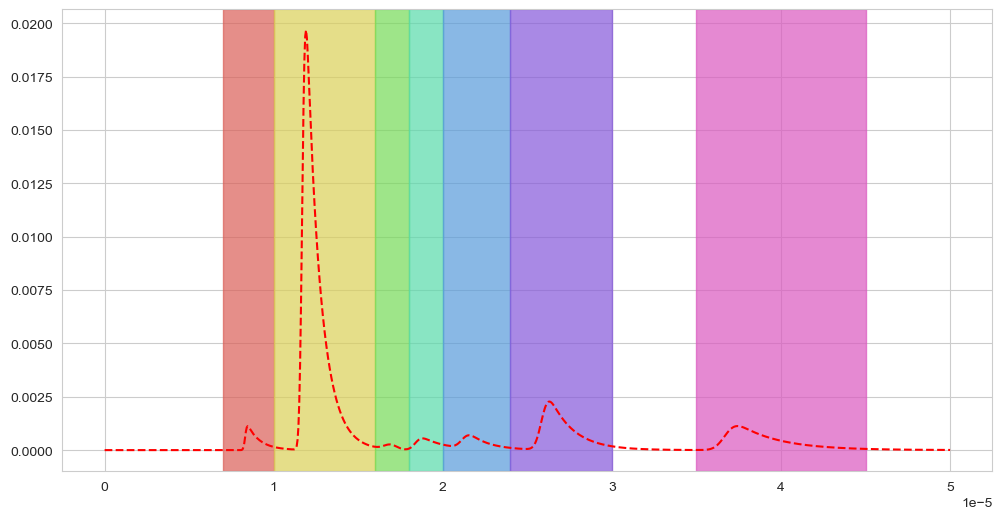

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
x_fit = np.linspace(0, 5e-5, 1000)
palette = sns.color_palette("hls",Npeaks)
ax.plot(x_fit, baseline(x_fit, *PEAK_FIT_PARAMS), label='Baseline',color='r',linestyle='--')
for i,r in enumerate(PEAK_RANGES):
    ax.axvspan(*r,color=palette[i],alpha=.7)
plt.show()

# Residuals
We can remove the calculated baseline from the data and look for some small peaks that can be a hint of the trapped fragments

In [10]:
runs = [427000+x for x in [97,300, 302, 304, 306, 307, 308, 309]] # 97,
# runs = [427000+x for x in [300,302,304,306]] # 306, 307, 308, 309
# load data
# df_raw = vl2.tof_df_creation(runs, 'C:\\ALPACA\\analysis\\volpe\\Databases')
# df_raw = pl.read_parquet("C:\\ALPACA\\analysis\\volpe\\Databases\\ToF_multifit_v2-427300-427309.parquet").rename({"__index_level_0__":"t_s"})
df_raw = pl.read_parquet("C:\\ALPACA\\analysis\\volpe\\Databases\\residuals_study-427097-427309.parquet").rename({"__index_level_0__":"t_s"})
print(df_raw)

shape: (50_002, 9)
┌─────────┬────────┬────────┬────────┬───┬────────┬────────┬────────┬───────────┐
│ 427097  ┆ 427300 ┆ 427302 ┆ 427304 ┆ … ┆ 427307 ┆ 427308 ┆ 427309 ┆ t_s       │
│ ---     ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---       │
│ f64     ┆ f64    ┆ f64    ┆ f64    ┆   ┆ f64    ┆ f64    ┆ f64    ┆ f64       │
╞═════════╪════════╪════════╪════════╪═══╪════════╪════════╪════════╪═══════════╡
│ 0.0     ┆ 0.0018 ┆ 0.0016 ┆ 0.003  ┆ … ┆ 0.0012 ┆ 0.0008 ┆ 0.0014 ┆ 0.0       │
│ -0.0002 ┆ 0.0016 ┆ 0.0002 ┆ 0.0032 ┆ … ┆ 0.0018 ┆ 0.0008 ┆ 0.001  ┆ 2.0000e-9 │
│ -0.0014 ┆ 0.0014 ┆ 0.0014 ┆ 0.0024 ┆ … ┆ 0.0008 ┆ 0.0008 ┆ 0.0014 ┆ 4.0000e-9 │
│ -0.0002 ┆ 0.0022 ┆ 0.0024 ┆ 0.002  ┆ … ┆ 0.0016 ┆ 0.001  ┆ 0.0022 ┆ 6.0000e-9 │
│ 0.0     ┆ 0.0024 ┆ 0.0026 ┆ 0.002  ┆ … ┆ 0.0018 ┆ 0.0006 ┆ 0.0016 ┆ 8.0000e-9 │
│ …       ┆ …      ┆ …      ┆ …      ┆ … ┆ …      ┆ …      ┆ …      ┆ …         │
│ 0.0004  ┆ 0.0024 ┆ 0.001  ┆ 0.0014 ┆ … ┆ 0.0002 ┆ 0.0012 ┆ 0.0018 ┆ 0.0001   

In [11]:
# TOF values for different particles estimated based on the energy (natural units)
SPEED_OF_LIGHT = 299792458 # m/s
PROTON_MASS = 938272.08816 # keV/c^2
ELECTRON_MASS = 0.511 # keV/c^2
L = 1.049 # m 
# L * sqrt( m / (2 V q) )

print(f"pbar -> {L*np.sqrt(PROTON_MASS / 2 / 0.180 / SPEED_OF_LIGHT**2)} s")
print(f"e- -> {L*np.sqrt(ELECTRON_MASS / 2 / 0.180 / SPEED_OF_LIGHT**2)} s")

pbar -> 5.648952636448862e-06 s
e- -> 4.1688280752088236e-09 s


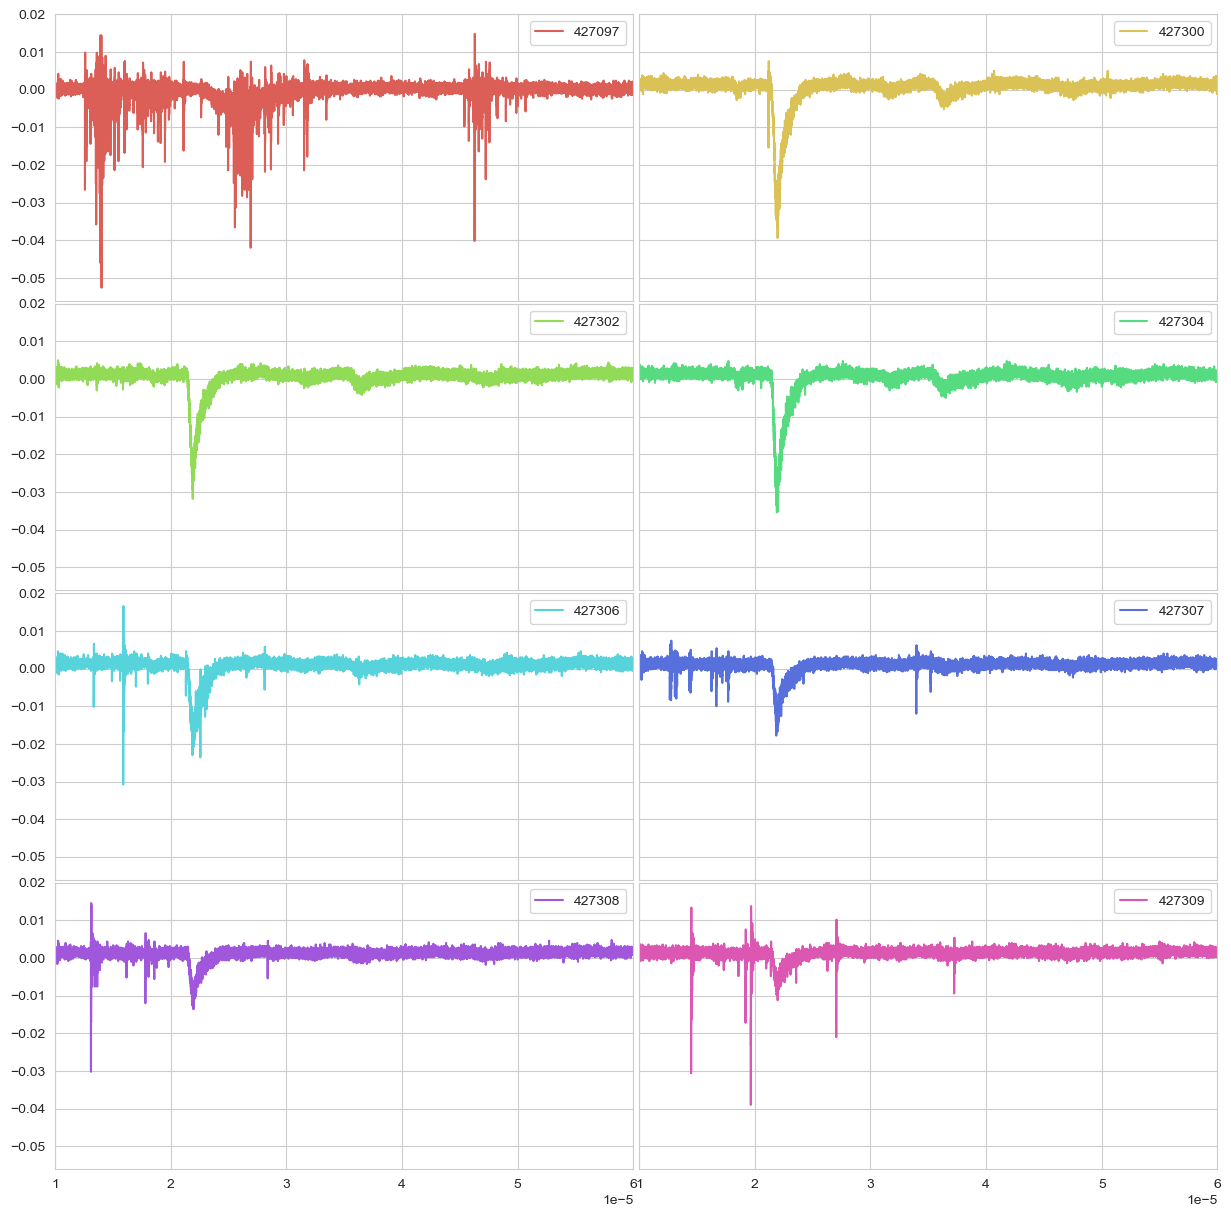

In [12]:
fig1 = plt.figure(figsize=(15,15))
ax1 = fig1.subplots(nrows=4,ncols=2,sharex=True,sharey=True,squeeze=True,gridspec_kw=dict(wspace=0.01,hspace=0.01)).flatten()
palette = sns.color_palette("hls",len(runs))

for i,run in enumerate(runs):
    ax1[i].plot(df_raw["t_s"],df_raw[f"{run}"],color=palette[i],label=run)
    ax1[i].legend()
    ax1[i].set_xlim(1e-5,6e-5)

# ax1.set_yscale("log")

### Clean up the data
1) remove the background - background is the signal that is seen for t<t0 (10 us)
2) calculate average signal from the runs and flip the data
3) remove the baseline
4) bin data - bins of 10 ns

In [25]:
T0_OFFSET = 1e-5     # Temporal offset
T_CUTOFF = 1.6e-5    # cutoff after which we have rinding
BIN_SIZE = 6e-9     # Size of the bin, in seconds


shape: (400_016, 6)
┌──────────┬────────┬─────────┬──────────┬──────────┬───────────┐
│ t_s      ┆ run    ┆ signal  ┆ bcg      ┆ bcg_std  ┆ signal_nb │
│ ---      ┆ ---    ┆ ---     ┆ ---      ┆ ---      ┆ ---       │
│ f64      ┆ i32    ┆ f64     ┆ f64      ┆ f64      ┆ f64       │
╞══════════╪════════╪═════════╪══════════╪══════════╪═══════════╡
│ -0.00001 ┆ 427097 ┆ 0.0     ┆ 0.000283 ┆ 0.000662 ┆ -0.000283 │
│ -0.00001 ┆ 427097 ┆ -0.0002 ┆ 0.000283 ┆ 0.000662 ┆ -0.000483 │
│ -0.00001 ┆ 427097 ┆ -0.0014 ┆ 0.000283 ┆ 0.000662 ┆ -0.001683 │
│ -0.00001 ┆ 427097 ┆ -0.0002 ┆ 0.000283 ┆ 0.000662 ┆ -0.000483 │
│ -0.00001 ┆ 427097 ┆ 0.0     ┆ 0.000283 ┆ 0.000662 ┆ -0.000283 │
│ …        ┆ …      ┆ …       ┆ …        ┆ …        ┆ …         │
│ 0.00009  ┆ 427309 ┆ 0.0018  ┆ 0.001349 ┆ 0.000663 ┆ 0.000451  │
│ 0.00009  ┆ 427309 ┆ 0.0004  ┆ 0.001349 ┆ 0.000663 ┆ -0.000949 │
│ 0.00009  ┆ 427309 ┆ 0.0022  ┆ 0.001349 ┆ 0.000663 ┆ 0.000851  │
│ 0.00009  ┆ 427309 ┆ 0.002   ┆ 0.001349 ┆ 0.000663 ┆ 0.

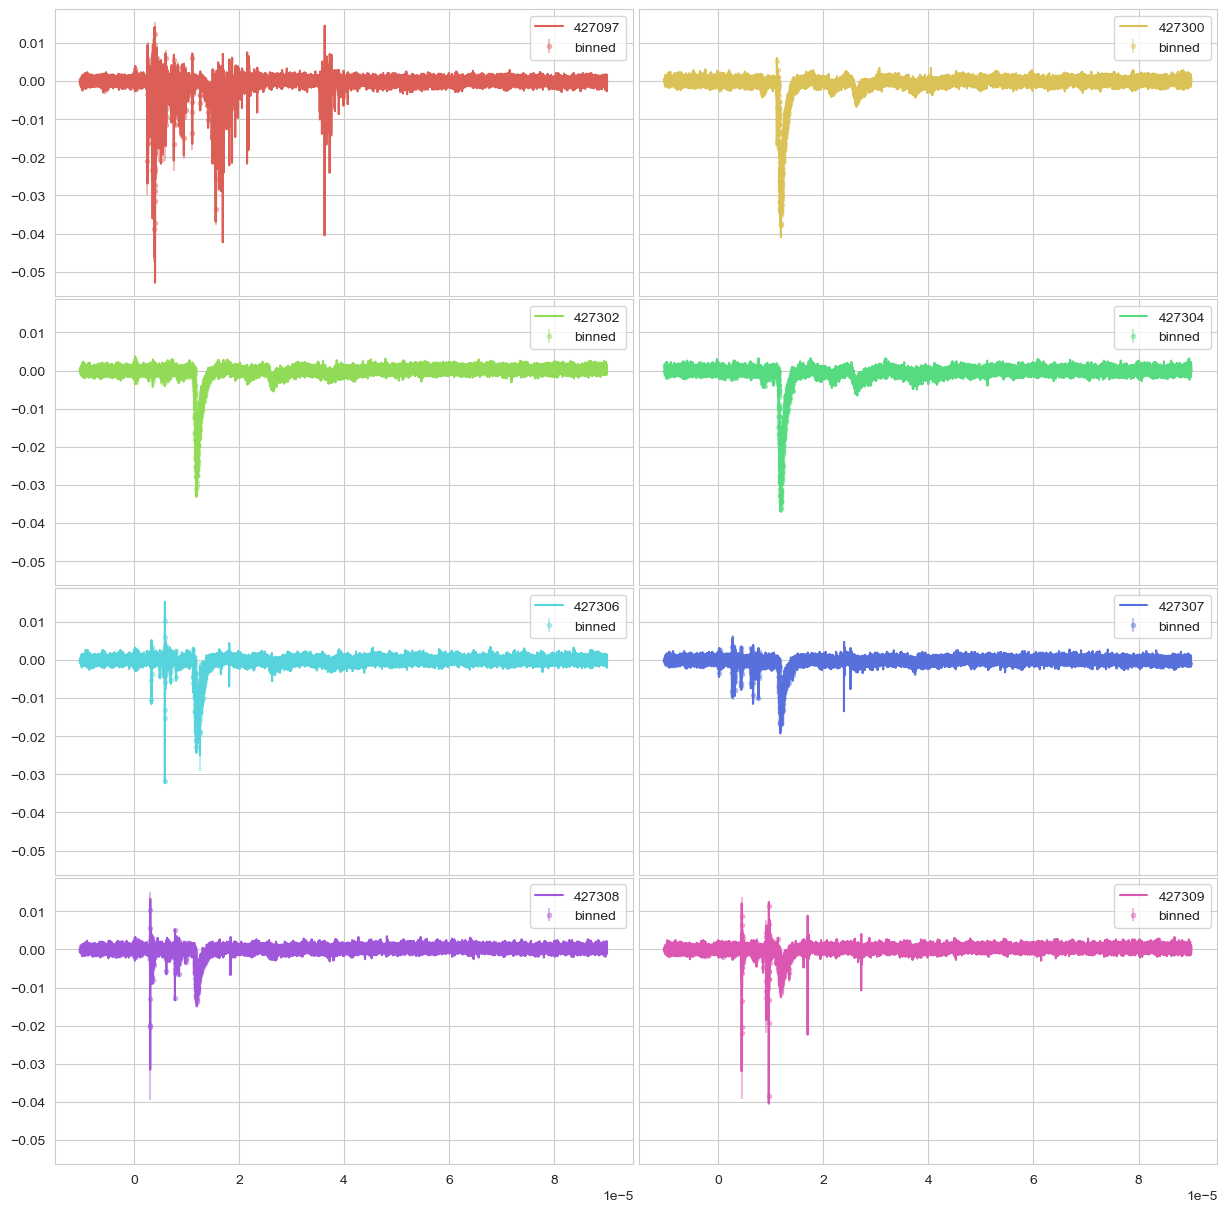

In [29]:
# calculate the backgrounds
df = df_raw.unpivot(value_name="signal",variable_name="run",index="t_s")
background_df = df.filter(pl.col("t_s").lt(T0_OFFSET)).group_by("run").agg(bcg=pl.col("signal").mean(),bcg_std=pl.col("signal").std())
df = (df.join(background_df,on=["run"]) # add backgrounds to the dataframe
      .with_columns(pl.col("signal").sub(pl.col("bcg")).alias("signal_nb"),
                    pl.col("t_s").sub(T0_OFFSET)) # remove background from the signal
      .sort("run",'t_s')
      .cast({"run":pl.Int32})
      .filter(pl.col("run").is_in(runs))
)
print(df)

# bin the data   
bins = np.arange(-T0_OFFSET,9e-5,BIN_SIZE)
bin_labels = [f"{bin + BIN_SIZE/2}" for bin in bins] + [f"{T_CUTOFF + BIN_SIZE/2}"]
df_binned = (df.with_columns(pl.col("t_s").cut(bins,labels=bin_labels).alias("t_s_bin"))
             .group_by(['run','t_s_bin']).agg(pl.col("signal_nb").mean().alias("signal"),
                                      pl.col("signal_nb").std().alias("signal_std")
                                      )
             .cast({"t_s_bin":pl.Float64})
             .sort("t_s_bin"))

print(df_binned)

fig_tmp = plt.figure(figsize=(15,15))
ax_tmp = fig_tmp.subplots(nrows=4,ncols=2,sharex=True,sharey=True,squeeze=True,gridspec_kw=dict(wspace=0.01,hspace=0.01)).flatten()
for i,run in enumerate(runs):
    df_run = df.filter(pl.col("run").eq(run))
    ax_tmp[i].plot(df_run["t_s"],df_run["signal_nb"],color=palette[i],label=run)
    df_run_binned = df_binned.filter(pl.col("run").eq(run),pl.col("t_s_bin").lt(T_CUTOFF))
    ax_tmp[i].errorbar(df_run_binned["t_s_bin"],df_run_binned["signal"],yerr=df_run_binned["signal_std"],fmt='.',label="binned",color=palette[i],alpha=0.4)
    ax_tmp[i].legend()

### FMT cleaning

Trying to remove high frequencies from the data



In [79]:
# FREQ_CUTOFF = 5e5

In [80]:
# fig_tmp = plt.figure(figsize=(30,15))
# ax_tmp = fig_tmp.subplots(nrows=len(runs),ncols=2,sharex=True,sharey=False,squeeze=True,gridspec_kw=dict(wspace=0.01,hspace=0.01)).flatten()

# for i,run in enumerate(runs):
#     df_binned_run = df_binned.filter(pl.col("run").eq(run))
#     t = df_binned_run['t_s_bin']
#     v = df_binned_run['signal']
#     n = len(t)
#     freq = np.fft.rfftfreq(n,BIN_SIZE)
#     fhat = np.fft.rfft(t, len(t))
#     mask = (freq >= 0) & (freq <= FREQ_CUTOFF) & (np.abs(fhat) <= 0.1)
#     fhat_changed = fhat.copy()
#     fhat_changed[~mask] = 0
#     ffilt = np.fft.irfft(fhat_changed)
#     ax_tmp[2*i].errorbar(df_binned_run["t_s_bin"],df_binned_run["signal"],yerr=df_binned_run["signal_std"],fmt='.',label="binned",color=palette[i],alpha=0.4)
#     ax_tmp[2*i+1].errorbar(t,ffilt,fmt='.',label="binned",color=palette[i],alpha=0.4)

### Fit the peaks
We need to create the baseline for each run

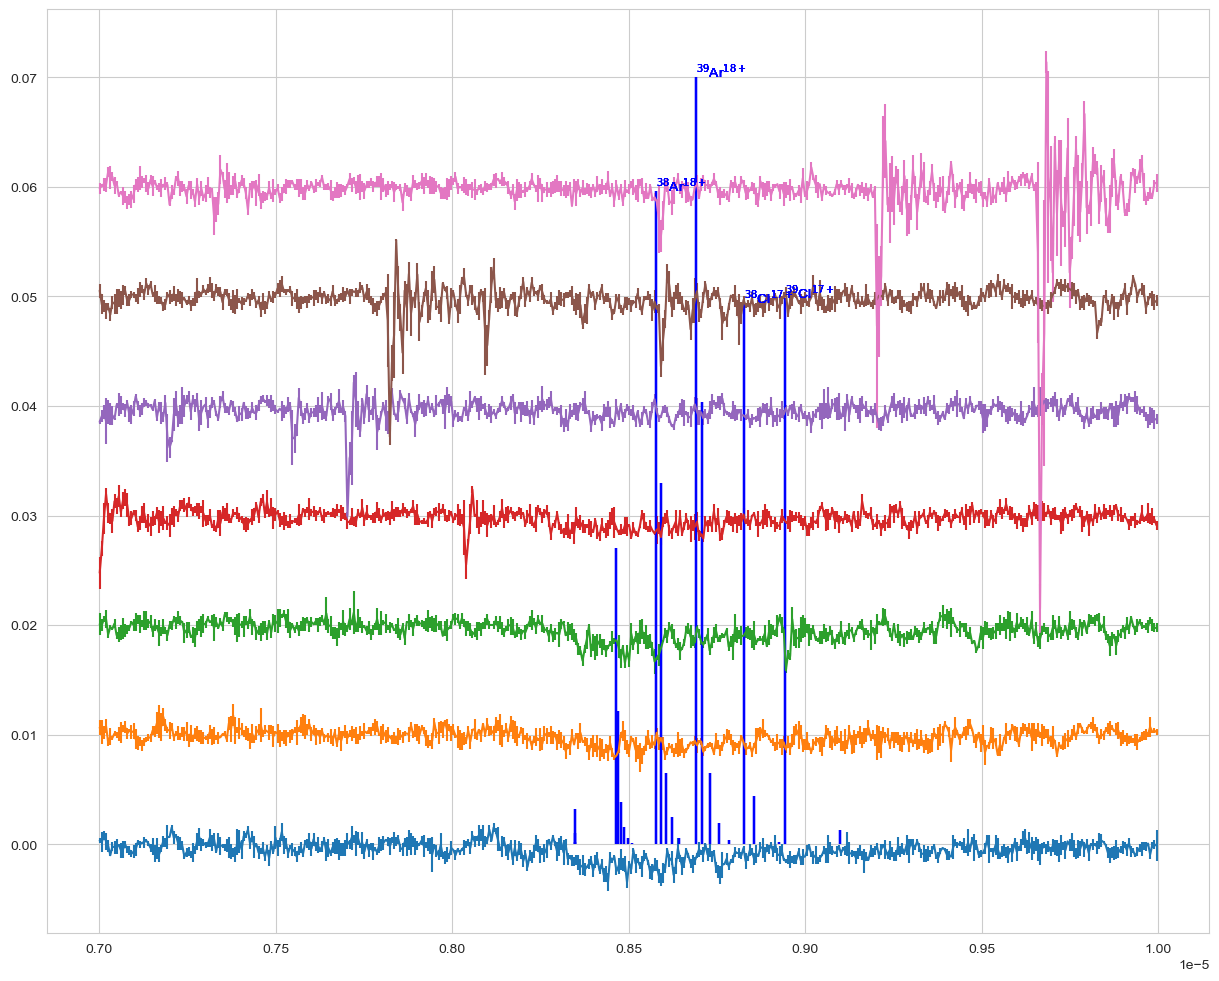

In [43]:
fig_tmp = plt.figure(figsize=(15,12))
# ax_tmp = fig_tmp.subplots(nrows=len(runs),ncols=1,sharex=[True,True],sharey=False,squeeze=True,gridspec_kw=dict(wspace=0.01,hspace=0.01)).flatten()
ax_tmp = fig_tmp.add_subplot()

fit_params = []

for i,run in enumerate(runs[1:]):
    df_binned_run = df_binned.filter(pl.col("run").eq(run))
    fit_params_i = PEAK_FIT_PARAMS.copy()
    for peak_no in range(1): # len(PEAK_RANGES)
        df_temp = df_binned_run.filter(pl.col("t_s_bin").is_between(*PEAK_RANGES[peak_no])).to_pandas().set_index("t_s_bin") # .filter(pl.col("t_s_bin").is_between(*PEAK_RANGES[peak_no]))
        # ax_tmp[i+peak_no].errorbar(df_temp.index,df_temp["signal"],yerr=df_temp['signal_std'])
        ax_tmp.errorbar(df_temp.index,df_temp["signal"]+0.01*i,yerr=df_temp['signal_std'])
        # indicate_fragments(ax_tmp[i+peak_no],lim=1e-3,isotope="Ar40",color=palette[0],offset=0)
        # fit_params_i[i], pcov = vl2.fit_n_plot(df_temp, PEAK_FIT_FNCS[peak_no], PEAK_FIT_PARAMS[peak_no], ['Ampl', 'mu', 'sigma', 'lam'])
        # fit_params.append(fit_params_i)
    indicate_fragments(ax_tmp,lim=7e-2,isotope="Ar40",color='b',offset=0)
    # indicate_fragments(ax_tmp,lim=7e-2,isotope="Ar40",color='g',offset=0,V=90)

shape: (12_501, 3)
┌──────────┬────────────────┬──────────┐
│ t_s      ┆ signal_nb_mean ┆ bcg_mean │
│ ---      ┆ ---            ┆ ---      │
│ f64      ┆ f64            ┆ f64      │
╞══════════╪════════════════╪══════════╡
│ -0.00001 ┆ -0.000074      ┆ 0.001276 │
│ -0.00001 ┆ 0.000051       ┆ 0.001276 │
│ -0.00001 ┆ 0.000351       ┆ 0.001276 │
│ -0.00001 ┆ -0.000349      ┆ 0.001276 │
│ -0.00001 ┆ -0.000224      ┆ 0.001276 │
│ …        ┆ …              ┆ …        │
│ 0.000015 ┆ 0.001201       ┆ 0.001276 │
│ 0.000015 ┆ 0.001376       ┆ 0.001276 │
│ 0.000015 ┆ 0.000426       ┆ 0.001276 │
│ 0.000015 ┆ 0.000876       ┆ 0.001276 │
│ 0.000015 ┆ 0.001376       ┆ 0.001276 │
└──────────┴────────────────┴──────────┘


C:\Users\jzielins\AppData\Local\Temp\ipykernel_18952\4250763873.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(df_averaged.to_pandas(),x="t_s",y="signal_nb_mean",palette=palette,ax=ax_tmp)


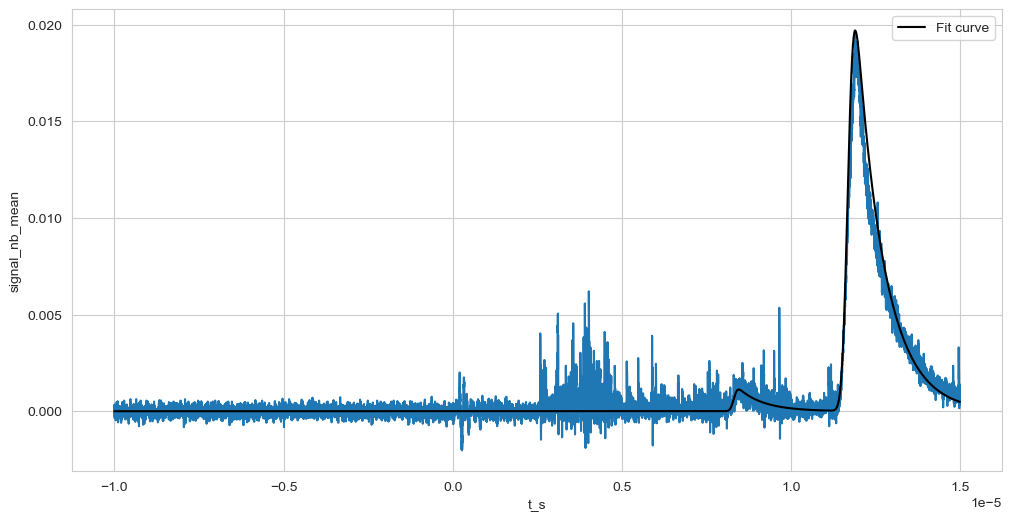

In [20]:
# average over all runs
df_averaged = (df.filter(pl.col("t_s").lt(T_CUTOFF))
               .group_by("t_s").agg(pl.col("signal_nb").mean().alias("signal_nb_mean").mul(-1),
                                    pl.col("bcg").mean().alias("bcg_mean"))
               .sort("t_s")
               )
print(df_averaged)

fig_tmp = plt.figure()
ax_tmp = fig_tmp.add_subplot()
palette = sns.color_palette("hls",len(runs))
sns.lineplot(df_averaged.to_pandas(),x="t_s",y="signal_nb_mean",palette=palette,ax=ax_tmp)
ax_tmp.plot(df_averaged['t_s'], peak_fit_all(df_averaged['t_s'], *fit_params), label='Fit curve',color=(0,0,0))
ax_tmp.legend()
# ax_tmp.set_xlim(0,7e-6)

C:\Users\jzielins\AppData\Local\Temp\ipykernel_6716\3832815651.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(df_residuals.to_pandas(),x="t_s",y="residuals",palette=palette,ax=ax_tmp)
C:\Users\jzielins\AppData\Local\Temp\ipykernel_6716\3832815651.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_tmp.legend()


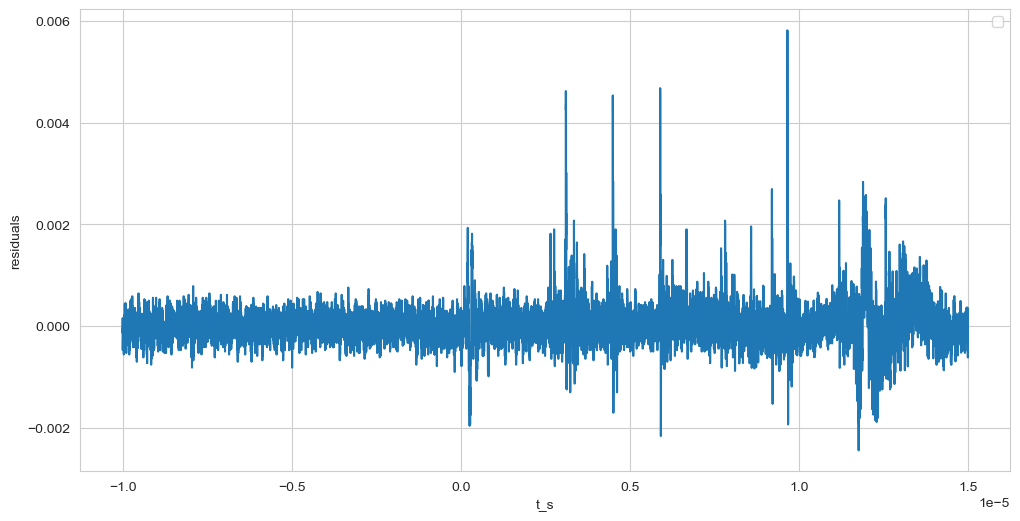

In [12]:
# remove the baseline
df_residuals = (df_averaged.with_columns(baseline=peak_fit_all(pl.Series(df_averaged.select("t_s")), *fit_params))
                .with_columns(pl.col("signal_nb_mean").sub(pl.col("baseline")).alias("residuals")))

fig_tmp = plt.figure()
ax_tmp = fig_tmp.add_subplot()
palette = sns.color_palette("hls",len(runs))
sns.lineplot(df_residuals.to_pandas(),x="t_s",y="residuals",palette=palette,ax=ax_tmp)
ax_tmp.legend()

shape: (2_501, 5)
┌──────────┬───────────┬────────────┬───────────┬───────────────┐
│ t_s_bin  ┆ signal    ┆ signal_std ┆ residuals ┆ residuals_std │
│ ---      ┆ ---       ┆ ---        ┆ ---       ┆ ---           │
│ f64      ┆ f64       ┆ f64        ┆ f64       ┆ f64           │
╞══════════╪═══════════╪════════════╪═══════════╪═══════════════╡
│ -0.00001 ┆ -0.000125 ┆ null       ┆ -0.000125 ┆ null          │
│ -0.00001 ┆ -0.000176 ┆ 0.000249   ┆ -0.000176 ┆ 0.000249      │
│ -0.00001 ┆ -0.000165 ┆ 0.000087   ┆ -0.000165 ┆ 0.000087      │
│ -0.00001 ┆ -0.000227 ┆ 0.000038   ┆ -0.000227 ┆ 0.000038      │
│ -0.00001 ┆ -0.000147 ┆ 0.000253   ┆ -0.000147 ┆ 0.000253      │
│ …        ┆ …         ┆ …          ┆ …         ┆ …             │
│ 0.000015 ┆ 0.000515  ┆ 0.000132   ┆ 0.000003  ┆ 0.00013       │
│ 0.000015 ┆ 0.000693  ┆ 0.000152   ┆ 0.000187  ┆ 0.000154      │
│ 0.000015 ┆ 0.000447  ┆ 0.000103   ┆ -0.000053 ┆ 0.000105      │
│ 0.000015 ┆ 0.000521  ┆ 0.000293   ┆ 0.000027  ┆ 0.000292

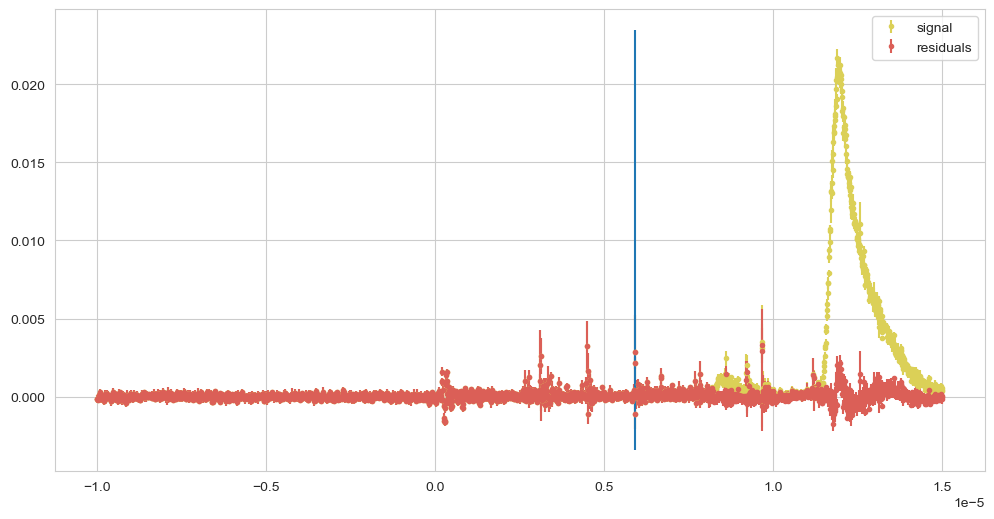

In [13]:
# bin the data
BIN_SIZE = 10e-9 # 10e-9                # Size of the bin, in seconds
bins = np.arange(-T0_OFFSET,T_CUTOFF,BIN_SIZE)
bin_labels = [f"{bin + BIN_SIZE/2}" for bin in bins] + [f"{T_CUTOFF + BIN_SIZE/2}"]
df_binned = (df_residuals.with_columns(pl.col("t_s").cut(bins,labels=bin_labels).alias("t_s_bin"))
             .group_by('t_s_bin').agg(pl.col("signal_nb_mean").mean().alias("signal"),
                                      pl.col("signal_nb_mean").std().alias("signal_std"),
                                      pl.col("residuals").mean().alias("residuals"),
                                      pl.col("residuals").std().alias("residuals_std"))
             .cast({"t_s_bin":pl.Float64})
             .sort("t_s_bin"))

print(df_binned)

fig_tmp = plt.figure()
ax_tmp = fig_tmp.add_subplot()
palette = sns.color_palette("hls",len(runs))
ax_tmp.errorbar(x=df_binned["t_s_bin"],y=df_binned["signal"],yerr=df_binned["signal_std"],color=palette[1],fmt='.',label="signal")
ax_tmp.errorbar(x=df_binned["t_s_bin"],y=df_binned["residuals"],yerr=df_binned["residuals_std"],color=palette[0],fmt='.',label="residuals")
ax_tmp.legend()
ax_tmp.vlines(vl2.tof_from_mq(1),ax_tmp.get_ylim()[0],ax_tmp.get_ylim()[1])
# ax_tmp.set_xlim(0.32e-5,0.43e-5)

Let's investigate the background a bit more

Conclusions: There is some ringing signal after each bigger peak. Let's try to remove it

5.905824494012623e-06
shape: (1_668, 3)
┌────────────┬─────────────┬────────────┐
│ t_s_bin    ┆ signal_mean ┆ signal_std │
│ ---        ┆ ---         ┆ ---        │
│ f64        ┆ f64         ┆ f64        │
╞════════════╪═════════════╪════════════╡
│ -0.00001   ┆ 0.0014      ┆ null       │
│ -0.00001   ┆ 0.001533    ┆ 0.000611   │
│ -0.00001   ┆ 0.0016      ┆ 0.0002     │
│ -0.00001   ┆ 0.002       ┆ 0.000346   │
│ -0.00001   ┆ 0.001533    ┆ 0.000462   │
│ …          ┆ …           ┆ …          │
│ -1.9000e-8 ┆ 0.002333    ┆ 0.000231   │
│ -1.3000e-8 ┆ 0.001933    ┆ 0.000902   │
│ -7.0000e-9 ┆ 0.001933    ┆ 0.000306   │
│ -1.0000e-9 ┆ 0.001933    ┆ 0.000987   │
│ 3.0000e-9  ┆ 0.0022      ┆ 0.000283   │
└────────────┴─────────────┴────────────┘
[1.73667586e-04 9.87647850e+06 3.70084862e+00 3.34616246e-05
 1.25382751e-05]
[ 1.56839622e-04  1.02117523e+07 -2.02868746e+01  2.65702691e-05
  7.61231363e-06]
[2.93823331e-04 9.77636327e+06 1.12164698e+01 5.32389326e-05
 7.74261389e-06]
[ 1.030

(0.0, 1.5e-05)

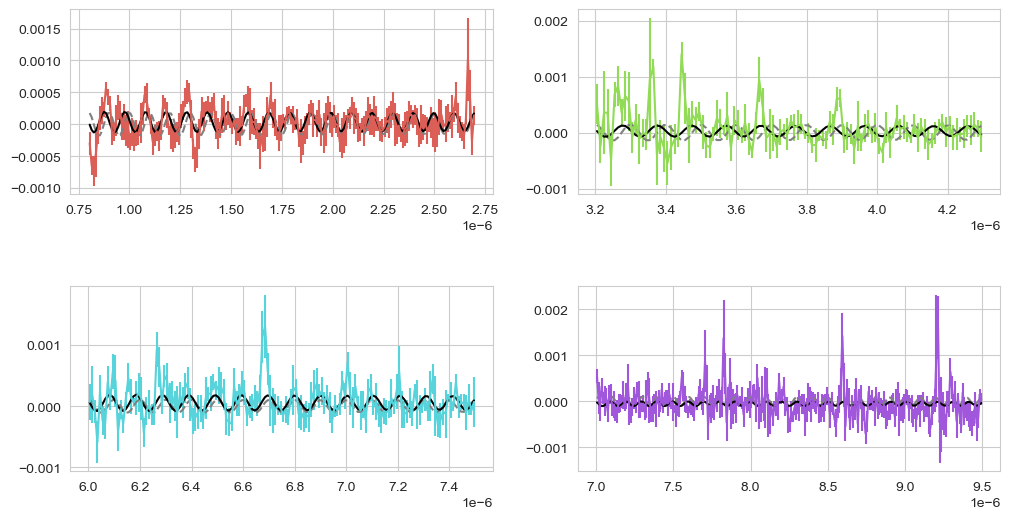

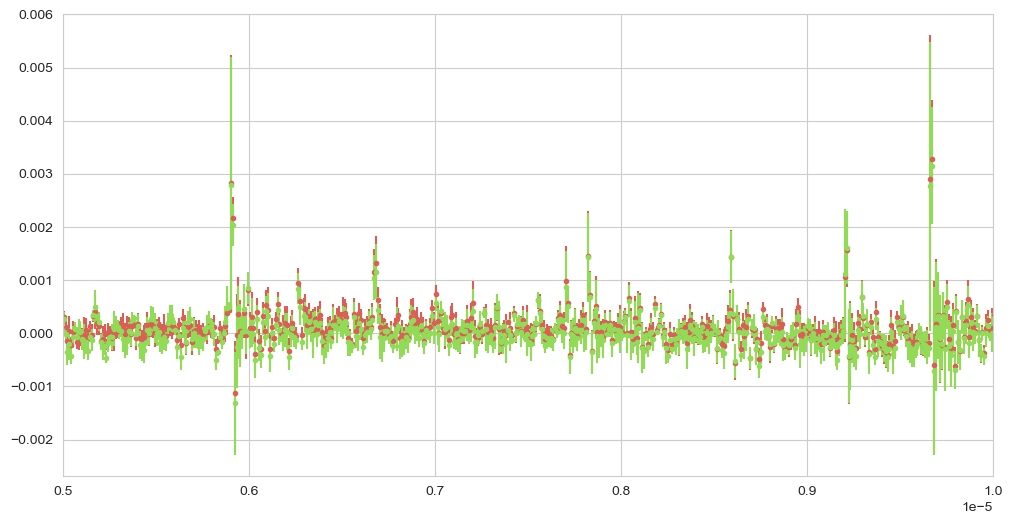

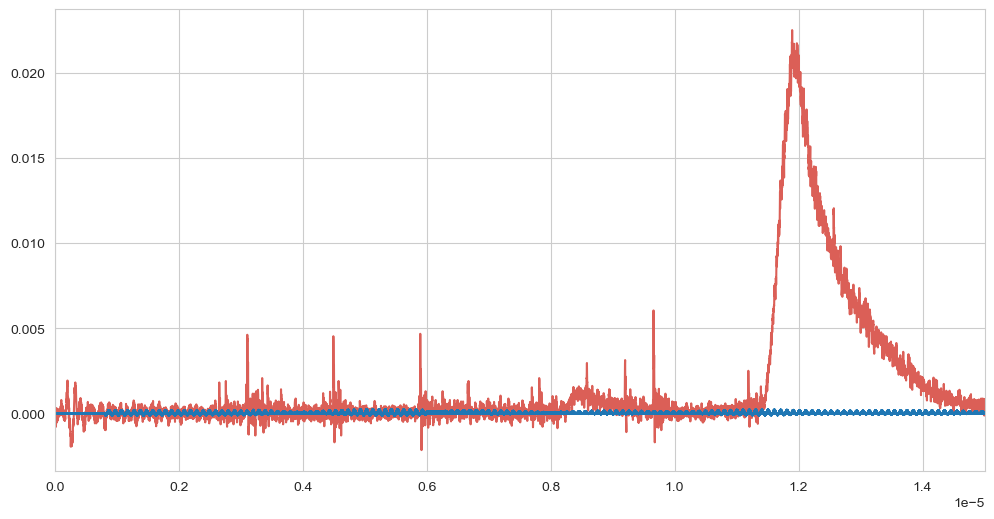

In [14]:
def oscillation(x, Ampl, freq, phi, offset, exp_tau):
    return Ampl*np.sin(2*np.pi*freq*x+phi)*np.exp(-x/exp_tau) + offset #+exp_ampl*np.exp(-x/exp_tau)

def cut_oscillation(x, start_oscillation, osc_params):
    return np.heaviside(x-start_oscillation, 0)*oscillation(x, *osc_params)

palette = sns.color_palette("hls",4)

fig1 = plt.figure()
ax1 = fig1.subplots(ncols=2,nrows=2,squeeze=True,gridspec_kw=dict(wspace=0.2,hspace=0.5))
# ax1 = fig1.add_subplot()
print(vl2.tof_from_mq(1))
df_cleanup = df_binned
print(df_run)
p0 = [[0.0002,1e7,1/2*np.pi,0,1e-5],[0.0002,1e7,1/2*np.pi,0,1e-5],[0.0002,1e7,1/2*np.pi,0,1e-5],[0.0002,1e7,1/2*np.pi,0,1e-5]]
popts = []
oscs_fit_range = [(0.08e-5,0.27e-5),(0.32e-5,0.43e-5),(0.6e-5,0.75e-5),(0.7e-5,  0.95e-5)] # (0.46e-5,0.56e-5),
for i in [0,1,2,3]:
    df_run = df_cleanup.filter(pl.col("t_s_bin").is_between(*oscs_fit_range[i]))
    ax1.flat[i].errorbar(x=df_run["t_s_bin"],y=df_run["residuals"],yerr=df_run["residuals_std"],color=palette[i])
    popt, pcov = curve_fit(f = oscillation, 
                            xdata = df_run["t_s_bin"], 
                            ydata = df_run["residuals"], 
                            p0 = p0[i],
                            sigma=df_run["residuals_std"],
                            absolute_sigma=False,
                            bounds=([-0.001,-np.inf,-np.inf,-0.001,0],[0.001,np.inf,np.inf,0.001,np.inf]),
                            maxfev=5000
                            )
    print(popt)
    popts.append(popt)
    df_cleanup = df_cleanup.with_columns(pl.col("residuals") - cut_oscillation(df_cleanup["t_s_bin"],oscs_fit_range[i][0],popt))
    ax1.flat[i].plot(df_run["t_s_bin"],cut_oscillation(df_run["t_s_bin"],oscs_fit_range[i][0],p0[i]),'--',color=(0.5,0.5,0.5))
    ax1.flat[i].plot(df_run["t_s_bin"],cut_oscillation(df_run["t_s_bin"],oscs_fit_range[i][0],popt),color=(0,0,0))


fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.errorbar(x=df_binned["t_s_bin"],y=df_binned["residuals"],yerr=df_binned["residuals_std"],color=palette[0],fmt='.',label="start")
ax2.errorbar(x=df_cleanup["t_s_bin"],y=df_cleanup["residuals"],yerr=df_cleanup["residuals_std"],color=palette[1],fmt='.',label="cleanup")
# ax2.plot(df_binned["t_s_bin"],cut_oscillation(df_binned["t_s_bin"],1e-6,popt),'--')
ax2.set_xlim(0.5e-5,1e-5)

def calculate_full_background(x,oscs_fit_range,popts):
    total = 0
    for i in range(len(popts)):
        total+= cut_oscillation(x,oscs_fit_range[i][0],popts[i])
    return total

fig3 = plt.figure()
ax3 = fig3.add_subplot()
# ax3.plot(df_binned["t_s_bin"],calculate_full_background(df_binned["t_s_bin"],oscs_fit_range,popts))
ax3.plot(df_averaged["t_s"],df_averaged["signal_nb_mean"],color=palette[0],label="start")
ax3.plot(df["t_s"],calculate_full_background(df["t_s"],oscs_fit_range,popts))
ax3.set_xlim(0,1.5e-5)

Result from fit of the signals:
<table>
    <tr>
        <td> Amp </td> <td> freq </td> <td> Phi </td> <td> offset </td> <td> Exp decay </td>
    </tr>
    <tr>
        <td> 1.56301649e-04 </td> <td> 9.91003716e+06 </td> <td> 3.44949537e+00 </td> <td> 4.02949634e-05 </td> <td> -9.22419204e+00 </td>
    </tr>
    <tr>
        <td> -1.50378357e-04 </td> <td> 1.00476525e+07 </td> <td> -2.61765019e-01 </td> <td> 2.05272762e-05 </td> <td> -4.17181786e-01 </td>
    </tr>
    <tr>
        <td> 1.31252484e-04 </td> <td> 9.59730718e+06 </td> <td> 1.60369688e+01 </td> <td> 6.07276567e-06 </td> <td> 1.33143287e+01 </td>
    </tr>
    <tr>
        <td> 4.86920936e-04 </td> <td> 9.88896528e+06 </td> <td> 6.90766191e+00 </td> <td> 4.22355380e-05 </td> <td> 3.62756639e-05 </td>
    </tr>
</table>
[ 1.56301649e-04,9.91003716e+06,3.44949537e+00,4.02949634e-05,-9.22419204e+00]
[-1.50378357e-04,1.00476525e+07,-2.61765019e-01,2.05272762e-05,-4.17181786e-01]
[1.31252484e-04,9.59730718e+06,1.60369688e+01, 6.07276567e-06, 1.33143287e+01]
[4.86920936e-04, 9.88896528e+06, 6.90766191e+00, 4.22355380e-05, 3.62756639e-05]

Result from fit of residuals
<table>
    <tr>
        <td> Amp </td> <td> freq </td> <td> Phi </td> <td> offset </td> <td> Exp decay </td>
    </tr>
    <tr>
        <td> 1.56301649e-04 </td> <td> 9.91003716e+06 </td> <td> 3.44949537e+00 </td> <td> 4.02949634e-05 </td> <td> -9.22419204e+00 </td>
    </tr>
    <tr>
        <td> -1.50378357e-04 </td> <td> 1.00476525e+07 </td> <td> -2.61765019e-01 </td> <td> 2.05272762e-05 </td> <td> -4.17181786e-01 </td>
    </tr>
    <tr>
        <td> 1.31252484e-04 </td> <td> 9.59730718e+06 </td> <td> 1.60369688e+01 </td> <td> 6.07276567e-06 </td> <td> 1.33143287e+01 </td>
    </tr>
    <tr>
        <td> 4.86920936e-04 </td> <td> 9.88896528e+06 </td> <td> 6.90766191e+00 </td> <td> 4.22355380e-05 </td> <td> 3.62756639e-05 </td>
    </tr>
</table>
[ 1.56301649e-04  9.91003716e+06  3.44949537e+00  4.02949634e-05 -9.22419204e+00]
[-1.50378357e-04  1.00476525e+07 -2.61765019e-01  2.05272762e-05 -4.17181786e-01]
[1.31252484e-04 9.59730718e+06 1.60369688e+01 6.07276567e-06 1.33143287e+01]
[4.86920936e-04 9.88896528e+06 6.90766191e+00 4.22355380e-05 3.62756639e-05]


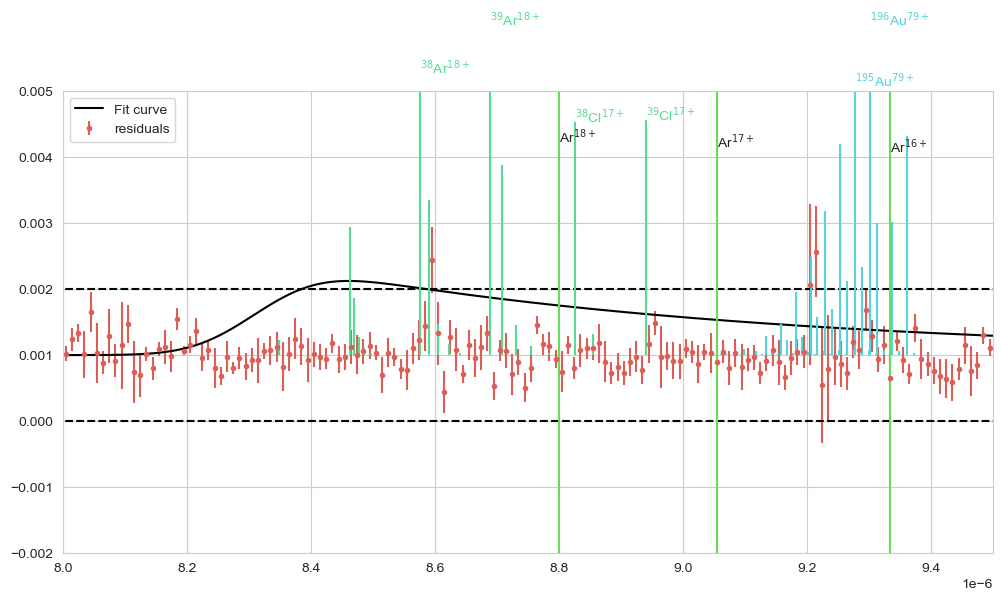

In [15]:
PLOT_OFFSET = 1e-3
bcg_threshold = 0.001

palette = sns.color_palette("hls",10)

fig_tmp = plt.figure()
ax_tmp = fig_tmp.add_subplot()

# ax_tmp.errorbar(x=df_binned["t_s_bin"],y=df_binned["signal"],yerr=df_binned["signal_std"],color=palette[1],fmt='.',label="signal")
ax_tmp.errorbar(x=df_binned["t_s_bin"],y=PLOT_OFFSET+df_binned["residuals"],yerr=df_binned["residuals_std"],color=palette[0],fmt='.',label="residuals")
# ax_tmp.errorbar(x=df_cleanup["t_s_bin"],y=PLOT_OFFSET+df_cleanup["residuals"],yerr=df_cleanup["residuals_std"],color=palette[1],fmt='.',label="after_cleanup")
ax_tmp.plot([-T0_OFFSET,T_CUTOFF],[PLOT_OFFSET+bcg_threshold]*2,'--',color=(0,0,0))
ax_tmp.plot([-T0_OFFSET,T_CUTOFF],[PLOT_OFFSET-bcg_threshold]*2,'--',color=(0,0,0))
ax_tmp.plot(df_binned['t_s_bin'],PLOT_OFFSET + peak_fit_all(df_binned['t_s_bin'], *fit_params), label='Fit curve',color=(0,0,0))
# ax_tmp.set_xlim(-T0_OFFSET,T_CUTOFF) # vl2.tof_from_mq(1)
# ax_tmp.set_xlim(vl2.tof_from_mq(1),1e-5)
ax_tmp.set_xlim(0.8e-5,0.95e-5) # vl2.tof_from_mq(1)
ax_tmp.set_ylim(-0.002,0.005)
# ax_tmp.set_ylim(PLOT_OFFSET-bcg_threshold*15,PLOT_OFFSET+bcg_threshold*15)
# ax_tmp.set_yscale("log")
ax_tmp.legend()

indicate_ionised_states(ax_tmp,tof_Ar40,q_Ar40,"Ar",palette[3])
indicate_fragments(ax_tmp,lim=PLOT_OFFSET+bcg_threshold*5,isotope="Ar40",color=palette[4],offset=PLOT_OFFSET)
indicate_fragments(ax_tmp,lim=PLOT_OFFSET+bcg_threshold*5,isotope="Au197",color=palette[5],offset=PLOT_OFFSET)

In [16]:
# print(df_binned.filter(pl.col("residuals").gt(bcg_threshold)).select(pl.col("t_s_bin")).equals(df_cleanup.filter(pl.col("residuals").gt(bcg_threshold)).select(pl.col("t_s_bin"))))
# print(pl.Series(df_binned.filter(pl.col("residuals").gt(bcg_threshold)).select(pl.col("t_s_bin"))))
# print(pl.Series(df_cleanup.filter(pl.col("residuals").gt(bcg_threshold)).select(pl.col("t_s_bin"))))
last_time = 0
for i,time in enumerate(pl.Series(df_binned.filter(pl.col("residuals").gt(bcg_threshold)).select(pl.col("t_s_bin"))).to_list()):
    if time -last_time < 0.1e-6:
        continue
    last_time = time
    print(time)

2.1499999999990143e-07
3.349999999999003e-07
2.664999999999878e-06
2.774999999999877e-06
3.1149999999998736e-06
3.3649999999998712e-06
4.50499999999986e-06
5.904999999999847e-06
6.674999999999838e-06
7.82499999999983e-06
8.59499999999982e-06
9.204999999999816e-06
9.664999999999812e-06
1.1194999999999795e-05
1.190499999999979e-05
1.2014999999999791e-05
1.213499999999979e-05
1.2574999999999786e-05
1.306499999999978e-05
1.3584999999999774e-05


# Fitting time

Peaks are expeceted at:

5.904999999999847e-06

6.674999999999838e-06

7.82499999999983e-06

8.59499999999982e-06

9.204999999999816e-06

9.664999999999812e-06

Ampl:	6.15434725450583e-11
mu:	5.908097345277863e-06
sigma:	6.281703478318256e-09
Condition number of the covariance matrix: 8.069502e+04
Diagonal values of pcov:
Cov of Ampl:	5.012561437588766e-22
Cov of mu:	3.2758166024778706e-18
Cov of sigma:	3.0934219219978937e-18
Chi-2: 153.76739989735324
dof:	147
Reduced Chi^2:	1.0460367339956003
Goodness-of-Fit:	0.3344965416688168
R-squared: 0.5344151597444738


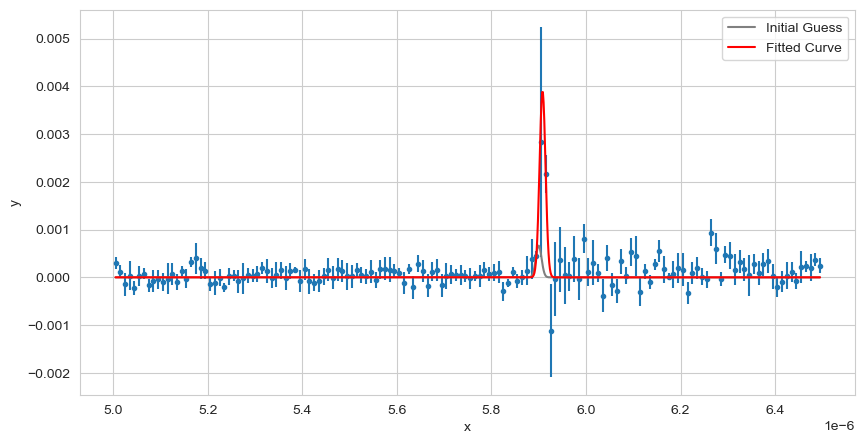

[6.15434725e-11 5.90809735e-06 6.28170348e-09]


In [17]:
# peak 1 expected at 5.904999999999847e-06
# df_peak1 = df_cleanup.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(5e-6,6.5e-6)).to_pandas().set_index("t_s_bin")
# par_peak1_i = [10e-12, 5.9e-6, 6e-9]

df_peak1 = df_binned.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(5e-6,6.5e-6)).to_pandas().set_index("t_s_bin")
par_peak1_i = [10e-12, 5.9e-6, 6e-9]

peak1_popt, peak1_pcov = vl2.fit_n_plot_errors(df_peak1, vl2.Gauss, par_peak1_i, ['Ampl', 'mu', 'sigma'], verbose=True)
print(peak1_popt)

Ampl:	3.605581801989615e-11
mu:	6.6818602570441385e-06
sigma:	1.0372938789951286e-08
Condition number of the covariance matrix: 9.855740e+04
Diagonal values of pcov:
Cov of Ampl:	8.022288639965121e-23
Cov of mu:	7.313883043566039e-18
Cov of sigma:	7.694099368978375e-18
Chi-2: 126.42696410386797
dof:	97
Reduced Chi^2:	1.3033707639574017
Goodness-of-Fit:	0.024010614404013975
R-squared: 0.11971718204379511


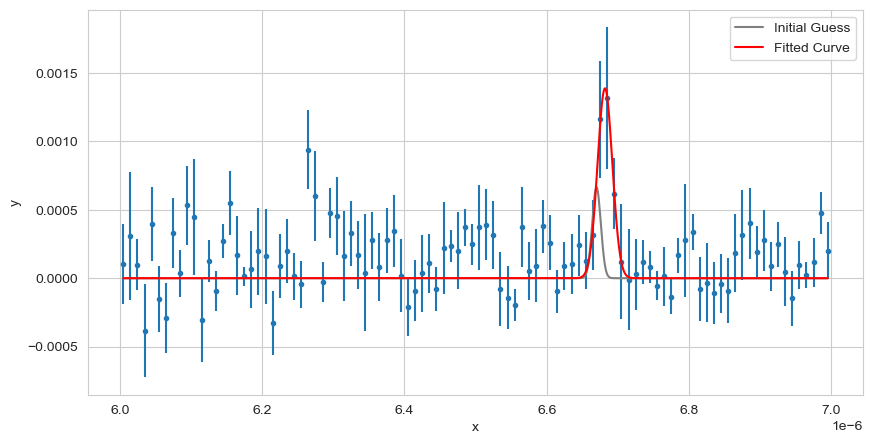

[3.60558180e-11 6.68186026e-06 1.03729388e-08]


In [18]:
# peak 2 expected at 6.674999999999838e-06
# df_peak2 = df_cleanup.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(6e-6,7e-6)).to_pandas().set_index("t_s_bin")
# par_peak2_i = [10e-12, 6.67e-6, 6e-9]

df_peak2 = df_binned.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(6e-6,7e-6)).to_pandas().set_index("t_s_bin")
par_peak2_i = [10e-12, 6.67e-6, 6e-9]

peak2_popt, peak2_pcov = vl2.fit_n_plot_errors(df_peak2, vl2.Gauss, par_peak2_i, ['Ampl', 'mu', 'sigma'], verbose=True)
print(peak2_popt)

Ampl:	2.2571783350020673e-11
mu:	7.828205784278358e-06
sigma:	4.919566558231443e-09
Condition number of the covariance matrix: 2.653078e+05
Diagonal values of pcov:
Cov of Ampl:	9.918509434604418e-23
Cov of mu:	1.1099287629088822e-17
Cov of sigma:	1.675159946564001e-17
Chi-2: 100.75902125502019
dof:	97
Reduced Chi^2:	1.038752796443507
Goodness-of-Fit:	0.37668171442373555
R-squared: 0.24806923117657498


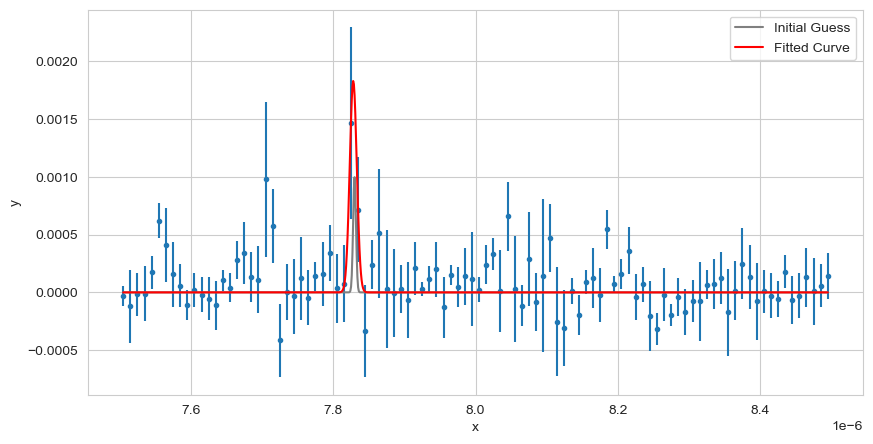

[2.25717834e-11 7.82820578e-06 4.91956656e-09]


In [19]:
# peak 3 expected at 7.82499999999983e-06
# df_peak3 = df_cleanup.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(0.778e-5,0.85e-5)).to_pandas().set_index("t_s_bin")
# par_peak3_i = [10e-12, 7.83e-6, 6e-9]

df_peak3 = df_binned.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(0.75e-5,0.85e-5)).to_pandas().set_index("t_s_bin")
par_peak3_i = [5e-12, 7.83e-6, 2e-9]

peak3_popt, peak3_pcov = vl2.fit_n_plot_errors(df_peak3, vl2.Gauss, par_peak3_i, ['Ampl', 'mu', 'sigma'], verbose=True)
print(peak3_popt)

Ampl:	2.2022444375854298e-11
mu:	8.59424144958621e-06
sigma:	6.053167153929765e-09
Condition number of the covariance matrix: 2.201885e+05
Diagonal values of pcov:
Cov of Ampl:	6.904312349023149e-23
Cov of mu:	9.619922172172431e-18
Cov of sigma:	4.698948120480374e-18
Chi-2: 80.22716921116354
dof:	77
Reduced Chi^2:	1.0419112884566695
Goodness-of-Fit:	0.3782515895528433
R-squared: 0.43592900325018913


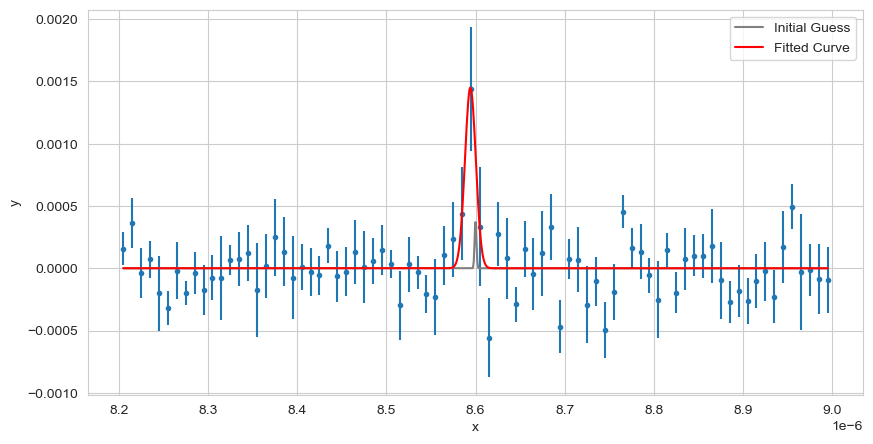

[2.20224444e-11 8.59424145e-06 6.05316715e-09]


In [20]:
# peak 4 expected at 8.59499999999982e-06
# df_peak4 = df_cleanup.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(0.82e-5,0.9e-5)).to_pandas().set_index("t_s_bin")
# par_peak4_i = [1e-12, 8.6e-6, 2e-9]
df_peak4 = df_binned.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(0.82e-5,0.9e-5)).to_pandas().set_index("t_s_bin")
par_peak4_i = [1e-12, 8.6e-6, 1e-9]
peak4_popt, peak2_pcov = vl2.fit_n_plot_errors(df_peak4, vl2.Gauss, par_peak4_i, ['Ampl', 'mu', 'sigma'], verbose=True)
print(peak4_popt)

Ampl:	4.948678504554753e-11
mu:	9.210275803446027e-06
sigma:	2.6862397018008648e-09
Condition number of the covariance matrix: 1.472282e+12
Diagonal values of pcov:
Cov of Ampl:	1.0450983148418668e-12
Cov of mu:	2.2651142942187172e-11
Cov of sigma:	5.335298273378329e-10
Chi-2: 43.95222989651178
dof:	47
Reduced Chi^2:	0.935153827585357
Goodness-of-Fit:	0.5995605183798407
R-squared: 0.5944042576367041


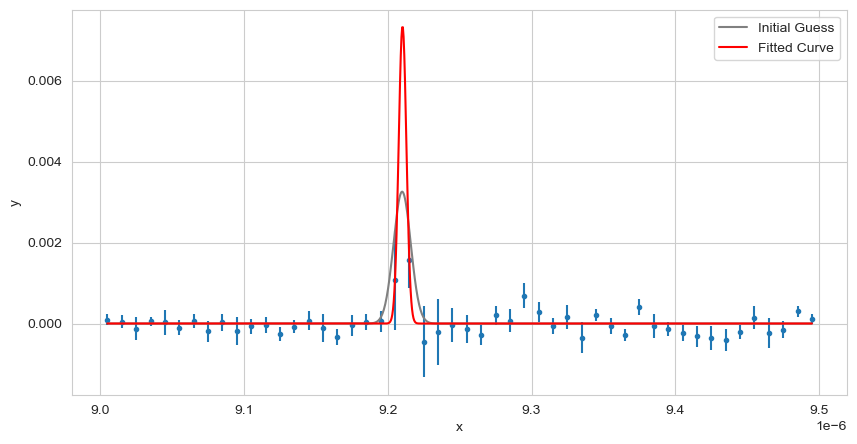

[4.9486785e-11 9.2102758e-06 2.6862397e-09]


In [21]:
# peak 5 expected at 9.204999999999816e-06
# df_peak5 = df_cleanup.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(0.9e-5,0.95e-5)).to_pandas().set_index("t_s_bin")
# par_peak5_i = [1e-11, 9.21e-6, 5e-9]

df_peak5 = df_binned.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(0.9e-5,0.95e-5)).to_pandas().set_index("t_s_bin")
par_peak5_i = [4.9e-11, 9.21e-6, 6e-9]

# test_popt, test_pcov = vl2.fit_n_plot_errors(df_test, peak_fit_func, par_test_i, ['Ampl', 'mu', 'sigma', 'lam'], verbose=True)
peak5_popt, peak5_pcov = vl2.fit_n_plot_errors(df_peak5, vl2.Gauss, par_peak5_i, ['Ampl', 'mu', 'sigma'], verbose=True)
print(peak5_popt)

Ampl:	1.5489438673217272e-10
mu:	9.670075314615215e-06
sigma:	2.435860185246073e-09
Condition number of the covariance matrix: 3.729991e+12
Diagonal values of pcov:
Cov of Ampl:	1.813750205234067e-10
Cov of mu:	1.6855579518961853e-11
Cov of sigma:	4.400135104050403e-09
Chi-2: 14.629929003255612
dof:	27
Reduced Chi^2:	0.5418492223428004
Goodness-of-Fit:	0.9743086685755981
R-squared: 0.8993995736270128


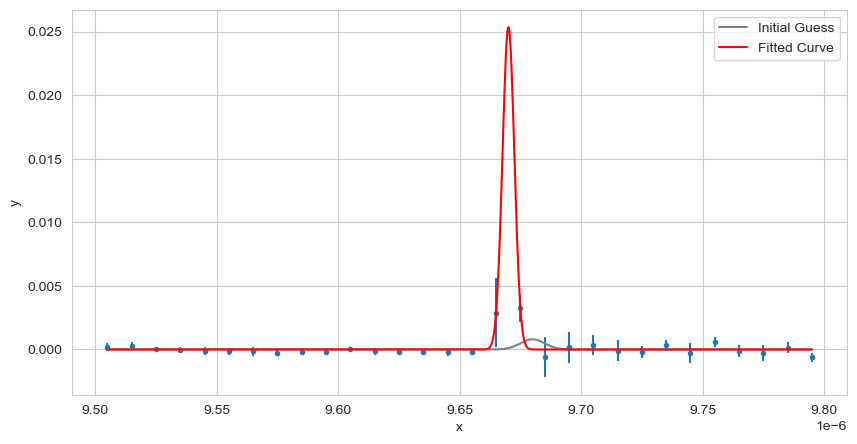

[1.54894387e-10 9.67007531e-06 2.43586019e-09]


In [22]:
# peak 6 expected at 9.664999999999812e-06
# df_peak6 = df_cleanup.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(9.5e-6,9.8e-6)).to_pandas().set_index("t_s_bin")
# par_peak6_i = [1e-11, 9.68e-6, 5e-9]

df_peak6 = df_binned.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(9.5e-6,9.8e-6)).to_pandas().set_index("t_s_bin")
par_peak6_i = [1e-11, 9.68e-6, 5e-9]

# test_popt, test_pcov = vl2.fit_n_plot_errors(df_test, peak_fit_func, par_test_i, ['Ampl', 'mu', 'sigma', 'lam'], verbose=True)
peak6_popt, peak6_pcov = vl2.fit_n_plot_errors(df_peak6, vl2.Gauss, par_peak6_i, ['Ampl', 'mu', 'sigma'], verbose=True)
print(peak6_popt)

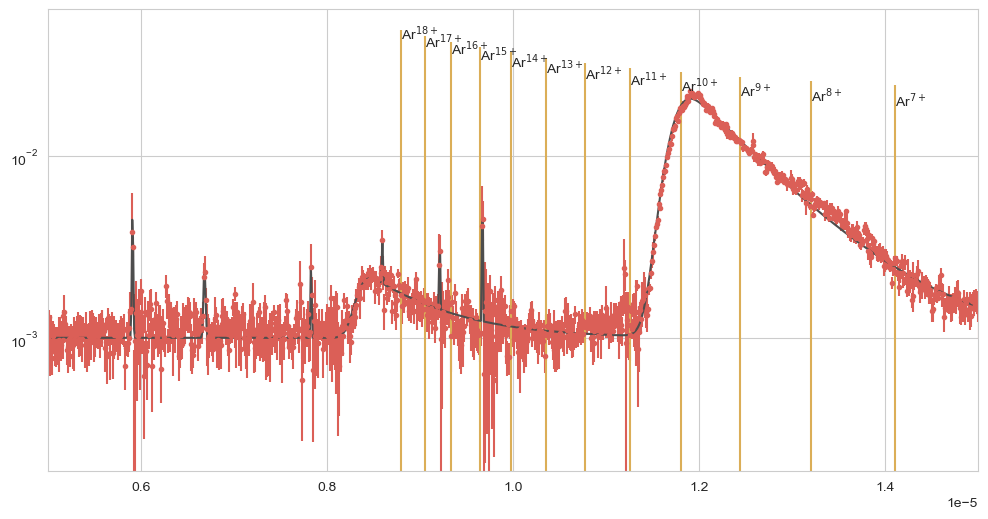

In [ ]:
def all_gaus_fits(x):
    total=0
    total += vl2.Gauss(x,*peak1_popt)
    total += vl2.Gauss(x,*peak2_popt)
    total += vl2.Gauss(x,*peak3_popt)
    total += vl2.Gauss(x,*peak4_popt)
    total += vl2.Gauss(x,*peak5_popt)
    total += vl2.Gauss(x,*peak6_popt)
    return total

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(x=df_binned["t_s_bin"],y=PLOT_OFFSET+df_binned["signal"],yerr=df_binned["signal_std"],fmt='.',color=palette[0],label="binned")
# ax.errorbar(x=df_cleanup["t_s_bin"],y=PLOT_OFFSET+df_cleanup["signal"],yerr=df_cleanup["signal_std"],fmt='.',color=palette[1],label="after clean up")
ax.set_xlim(5e-6,1.5e-5)
indicate_ionised_states(ax,tof_Ar40,q_Ar40,"Ar",palette[1])
# indicate_ionised_states(ax,tof_S32,q_S32,"S",palette[2])
# indicate_fragments(ax,lim=PLOT_OFFSET+bcg_threshold*5,isotope="Au197",color=palette[3],offset=PLOT_OFFSET)
# indicate_fragments(ax,lim=PLOT_OFFSET+bcg_threshold*5,isotope="Ar40",color=palette[4],offset=PLOT_OFFSET)
# ax.plot(df_binned["t_s_bin"],PLOT_OFFSET+all_gaus_fits(df_binned["t_s_bin"]),'-',color=(0,0,0))
ax.plot(df_binned["t_s_bin"],PLOT_OFFSET+all_gaus_fits(df_binned["t_s_bin"]) + peak_fit_all(df_binned['t_s_bin'], *fit_params),'-',color=(0.3,0.3,0.3))
ax.set_yscale("log")

Ampl:	6.15434725450583e-11
mu:	5.908097345277863e-06
sigma:	6.281703478318256e-09
Condition number of the covariance matrix: 8.069502e+04
Diagonal values of pcov:
Cov of Ampl:	5.012561437588766e-22
Cov of mu:	3.2758166024778706e-18
Cov of sigma:	3.0934219219978937e-18
Chi-2: 153.76739989735324
dof:	147
Reduced Chi^2:	1.0460367339956003
Goodness-of-Fit:	0.3344965416688168
R-squared: 0.5344151597444738


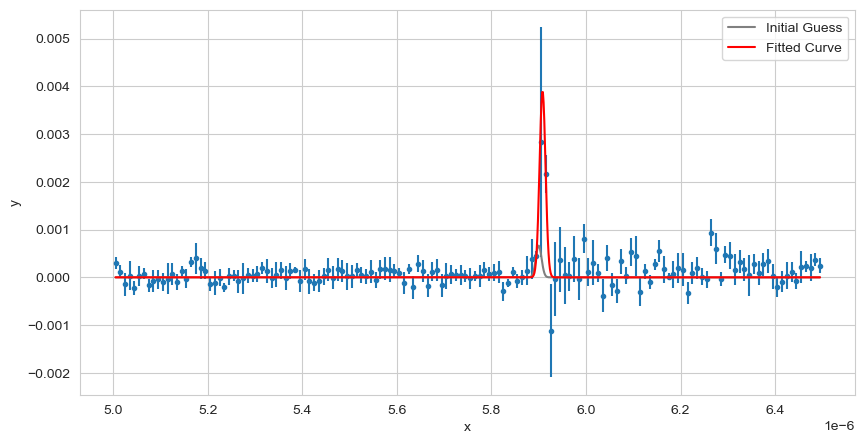

[6.15434725e-11 5.90809735e-06 6.28170348e-09]


In [24]:
# peak 1 expected at 5.904999999999847e-06
# df_peak1 = df_cleanup.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(5e-6,6.5e-6)).to_pandas().set_index("t_s_bin")
# par_peak1_i = [10e-12, 5.9e-6, 6e-9]

df_peak1 = df_binned.select("t_s_bin","residuals","residuals_std").filter(pl.col("t_s_bin").is_between(5e-6,6.5e-6)).to_pandas().set_index("t_s_bin")
par_peak1_i = [10e-12, 5.9e-6, 6e-9]

peak1_popt, peak1_pcov = vl2.fit_n_plot_errors(df_peak1, vl2.Gauss, par_peak1_i, ['Ampl', 'mu', 'sigma'], verbose=True)
print(peak1_popt)

In [25]:
# collect peak results
peak_popts = [peak1_popt,peak2_popt,peak3_popt,peak4_popt,peak5_popt,peak6_popt]
peak_results = pl.DataFrame({"peak":[i+1 for i in range(len(peak_popts))], "amp":[params[0] for params in peak_popts],"mu":[params[1] for params in peak_popts],"sigma":[params[2] for params in peak_popts]})

# calculate m/q for each peak
mq_peaks, mq_peaks_std = vl2.mq_from_tof(peak_results["mu"],peak_results["sigma"])
peak_results = peak_results.with_columns(pl.Series(mq_peaks).alias("m/q"),pl.Series(mq_peaks_std).alias("m/q std"))
print(peak_results)

print(df_sim_Ar40)

pl.Config.set_tbl_rows(70)
pl.Config.set_fmt_table_cell_list_len(100)
pl.Config.set_float_precision(20)
    
df_ions = pl.DataFrame({"m_over_q":list(mq_Ar40)+list(mq_S32)+list(mq_O16)+list(mq_N14),
                        "q":list(q_Ar40)+list(q_S32)+list(q_O16)+list(q_N14),
                        "symbol":["Ar"]*len(mq_Ar40) + ["S"]*len(mq_S32) + ["O"]*len(mq_O16) + ["N"]*len(mq_N14) 
                        })
# print(df_ions)
df_ions = (df_ions.with_columns(symbol=pl.concat_str(pl.col("symbol"),pl.col("q"),pl.lit("+")),
                                label=pl.concat_str(pl.lit("symbol"),pl.lit(r"$^{"),pl.col("q"),pl.lit(r"}+$"))))

# "label":[r"$^{40}$Ar$^{"+f"{q}"+r"+}$" for q in q_Ar40] + [r"$^{32}$S$^{"+f"{q}"+r"+}$" for q in q_S32] + [r"$^{16}$O$^{"+f"{q}"+r"+}$" for q in q_O16] + [r"$^{14}$N$^{"+f"{q}"+r"+}$" for q in q_N14],
#                         "symbol":[f"Ar{q}+" for q in q_Ar40] + [f"S{q}+" for q in q_S32] + [f"O{q}+" for q in q_O16] + [f"N{q}+" for q in q_N14]
for i in range(6):
    print(f"peak #{i+1}")
    lower = peak_results.filter(pl.col("peak").eq(i+1)).select(pl.col("m/q").sub(pl.col("m/q std"))).item()
    upper = peak_results.filter(pl.col("peak").eq(i+1)).select(pl.col("m/q").add(pl.col("m/q std"))).item()
    mq_peak = peak_results.filter(pl.col("peak").eq(i+1)).select(pl.col("m/q")).item()
    candidates1 = (df_sim_Ar40
                   .with_columns(average_mq=pl.col("m_over_q").mul(pl.col("trappable_count").truediv(pl.col("trappable_count").sum())).sum())
                   .filter(pl.col("m_over_q").is_between(lower,upper))
                  .with_columns(peak=pl.lit(i+1))
                  .group_by("peak")
                  .agg(candidates=pl.col("fragment"),
                       labels=pl.col("label"),
                       candidate_mq=pl.col("m_over_q"),
                       count=pl.col("trappable_count").sum(),
                       weighted_mq= pl.col("m_over_q").mul(pl.col("trappable_count").truediv(pl.col("trappable_count").sum())).sum(),
                       avergae_mq=pl.col("average_mq").first())
                    .with_columns(candidate_mq_diff=(pl.col("weighted_mq") - mq_peak) / mq_peak)
    )
    print("Fragments from Ar40")
    print(candidates1)

    print("Fragments from Au197")
    candidates2 = (df_sim_Au197
                   .with_columns(average_mq=pl.col("m_over_q").mul(pl.col("trappable_count").truediv(pl.col("trappable_count").sum())).sum())
                   .filter(pl.col("m_over_q").is_between(lower,upper))
                  .with_columns(peak=pl.lit(i+1))
                  .group_by("peak")
                  .agg(candidates=pl.col("fragment"),
                       labels=pl.col("label"),
                       candidate_mq=pl.col("m_over_q"),
                       count=pl.col("trappable_count").sum(),
                       weighted_mq= pl.col("m_over_q").mul(pl.col("trappable_count").truediv(pl.col("trappable_count").sum())).sum(),
                       avergae_mq=pl.col("average_mq").first())
                    .with_columns(candidate_mq_diff=(pl.col("weighted_mq") - mq_peak) / mq_peak)
    )
    print(candidates2)
    

    print("Ions condidates")
    candidates3 = (df_ions.filter(pl.col("m_over_q").is_between(lower,upper))
                  .with_columns(peak=pl.lit(i+1))
                  .group_by("peak")
                  .agg(candidates=pl.col("symbol"),
                       labels=pl.col("label"),
                       candidate_mq=pl.col("m_over_q"),
                       candidate_mq_diff=(pl.col("m_over_q") - mq_peak) / mq_peak))
    print(candidates3)
    print(pl.Series(candidates3.select("candidate_mq")).to_list())
    print(pl.Series(candidates3.select("candidate_mq_diff")).to_list())
    candidates = (pl.concat([candidates1.select("peak","candidates"),
                     candidates2.select("peak","candidates"),
                     candidates3.select("peak","candidates")])
                     .group_by("peak").agg(pl.concat_list("candidates"))
                     .select("candidates"))
    if candidates.is_empty():
        print([[]])
    else:
        print(candidates.item())
    print("================================================")

shape: (6, 6)
┌──────┬────────────┬──────────┬───────────┬──────────┬──────────┐
│ peak ┆ amp        ┆ mu       ┆ sigma     ┆ m/q      ┆ m/q std  │
│ ---  ┆ ---        ┆ ---      ┆ ---       ┆ ---      ┆ ---      │
│ i64  ┆ f64        ┆ f64      ┆ f64       ┆ f64      ┆ f64      │
╞══════╪════════════╪══════════╪═══════════╪══════════╪══════════╡
│ 1    ┆ 6.1543e-11 ┆ 0.000006 ┆ 6.2817e-9 ┆ 1.00077  ┆ 0.013729 │
│ 2    ┆ 3.6056e-11 ┆ 0.000007 ┆ 1.0373e-8 ┆ 1.28007  ┆ 0.017798 │
│ 3    ┆ 2.2572e-11 ┆ 0.000008 ┆ 4.9196e-9 ┆ 1.756966 ┆ 0.023914 │
│ 4    ┆ 2.2022e-11 ┆ 0.000009 ┆ 6.0532e-9 ┆ 2.117649 ┆ 0.028855 │
│ 5    ┆ 4.9487e-11 ┆ 0.000009 ┆ 2.6862e-9 ┆ 2.432116 ┆ 0.032993 │
│ 6    ┆ 1.5489e-10 ┆ 0.00001  ┆ 2.4359e-9 ┆ 2.681011 ┆ 0.036361 │
└──────┴────────────┴──────────┴───────────┴──────────┴──────────┘
shape: (58, 7)
┌──────────┬──────────┬───────────────────┬─────────────────┬─────────────┬──────────┬───────────┐
│ m_over_q ┆ fragment ┆ label             ┆ trappable_count ┆ total_